In [2]:
import jax
import os

In [3]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-12 16:34:38.050660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [4]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


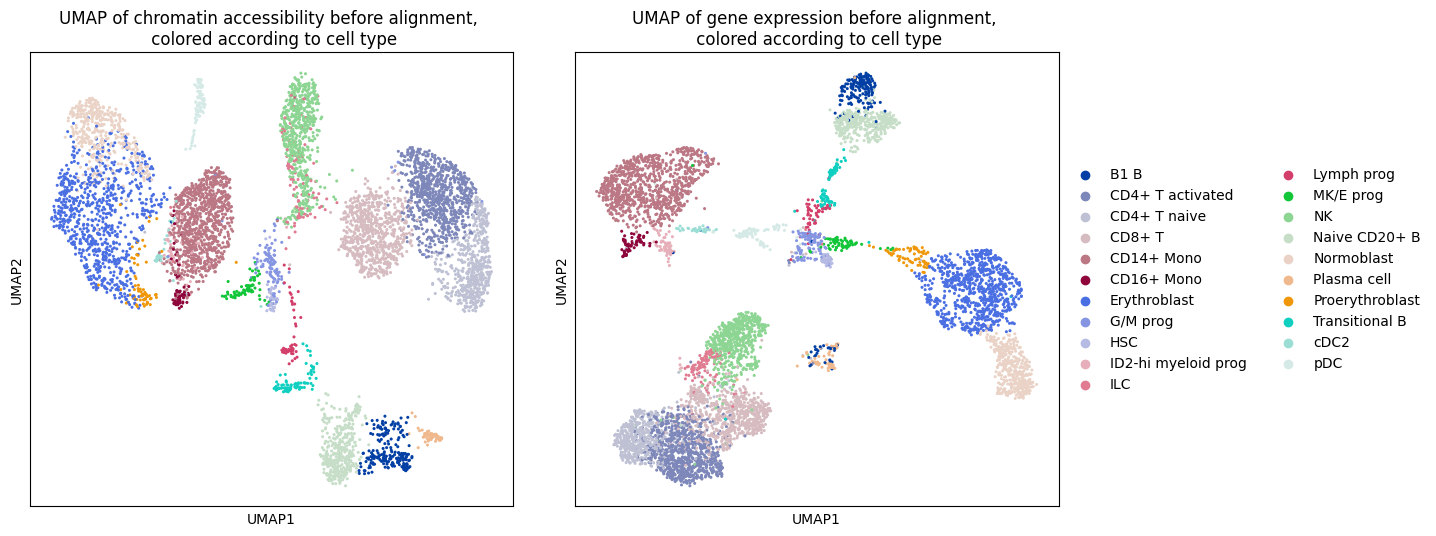

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [5]:
source_q = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
) 
target_q = adata_rna.obsm["GEX_X_pca"]

source_fused = sc.pp.pca(adata_atac.obsm["geneactivity_scvi"], n_comps=10)
target_fused = sc.pp.pca(adata_rna.obsm["geneactivity_scvi"], n_comps=10)

In [9]:
source = np.concatenate((source_fused, source_q), axis=1)
target = np.concatenate((target_fused, target_q), axis=1)

In [10]:
target_red = target[~adata_rna.obs["cell_type"].isin(["Proerythroblast", "Normoblast", "Erythroblast"])]

In [11]:
neural_net = MLP_vector_field(target.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target.shape[1], 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=0.1, linear_ot_solver=linear_ot_solver)


mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=0.95, tau_b=0.95, scale_cost="mean", input_dim=source.shape[1], output_dim=target.shape[1], iterations=10_000, ot_solver=solver, k_noise_per_x=1, fused_penalty = 1.0, split_dim=source_fused.shape[1])



2023-09-12 17:07:03.099158: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:445] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-09-12 17:07:03.099387: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:449] Memory usage: 26260406272 bytes free, 34079899648 bytes total.
2023-09-12 17:07:03.111834: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:459] Possibly insufficient driver version: 530.30.2


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [9]:
otfm(source, target_red, 1024, 1024)

100%|██████████| 10000/10000 [58:08<00:00,  2.87it/s] 


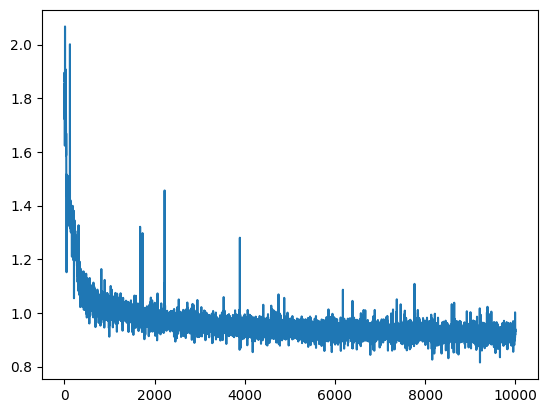

In [10]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

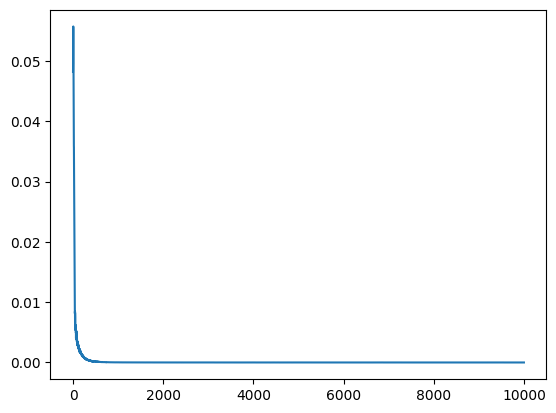

In [11]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss_eta"])

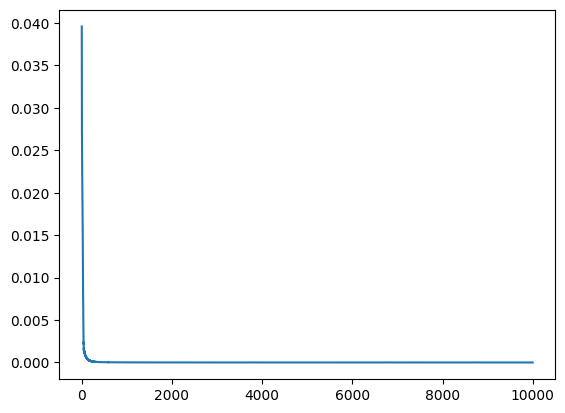

In [12]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss_xi"])

In [13]:

res = [None] * 10

for i in range(10):
    res[i] = otfm.transport(source, seed=i)[0][0,...]

gex_predicted = jnp.mean(np.asarray(res), axis=0)

In [14]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [15]:
gex_predicted_subset = gex_predicted[~adata_atac.obs["cell_type"].isin(["Proerythroblast"]).values]

In [16]:
gex_predicted.shape

(6224, 60)

In [18]:
import scipy
foscttm(gex_predicted_subset, target_red)

0.4791

In [ ]:
import scipy
foscttm(res[0][~adata_atac.obs["cell_type"].isin(["Proerythroblast"]).values], target_red)

In [9]:
r = otfm.match_fn(jax.random.PRNGKey(0), source, target_red)

In [24]:
r[0].shape, r[1].shape, r[2].shape, r[3].shape

((6159, 48), (6159, 1, 60), (6159,), (6224,))

In [ ]:
from ott.geometry import costs, geometry, graph, pointcloud
from ott.problems.linear import linear_problem
from ott.problems.quadratic import quadratic_problem
from ott.solvers import was_solver
from ott.solvers.linear import sinkhorn
from ott.solvers.nn.models import ModelBase, NeuralTrainState
from ott.solvers.quadratic import gromov_wasserstein

x=source
y=target_red

split_dim=source_fused.shape[1]
scale_cost="mean"
cost_fn=costs.SqEuclidean()

geom_xx = pointcloud.PointCloud(
    x=x[..., split_dim:], y=x[..., split_dim:], cost_fn=cost_fn, scale_cost=scale_cost
)
geom_yy = pointcloud.PointCloud(
    x=y[..., split_dim:], y=y[..., split_dim:], cost_fn=cost_fn, scale_cost=scale_cost
)
if split_dim > 0:
    geom_xy = pointcloud.PointCloud(
        x=x[..., :split_dim], y=y[..., :split_dim], cost_fn=cost_fn, scale_cost=scale_cost
    )

prob = quadratic_problem.QuadraticProblem(
    geom_xx, geom_yy, geom_xy, fused_penalty=fused_penalty, tau_a=tau_a, tau_b=tau_b
)
out = solver(prob)

In [28]:
np.max(r[2]), np.min(r[2]), np.max(r[3]), np.min(r[3])

(Array(0.00016354, dtype=float32),
 Array(0.00016298, dtype=float32),
 Array(0.00016187, dtype=float32),
 Array(0.00016033, dtype=float32))

In [16]:
adata_rna_red = adata_rna[~adata_rna.obs["cell_type"].isin(["Proerythroblast"])]

In [19]:
import scanpy as sc
adata = sc.concat(
    [adata_rna_red, adata_rna_red],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (r[0], jnp.squeeze(r[1])), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"])
#ax1.legend()
#ax1.set_title("Colored based on modality")
#sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
#ax2.set_title("Colored based on cell types")
#plt.tight_layout(pad=3.0)
#plt.show()

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 48 and the array at index 1 has size 60

In [ ]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (res[0], target), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
foscttm(gex_predicted, target)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, bu

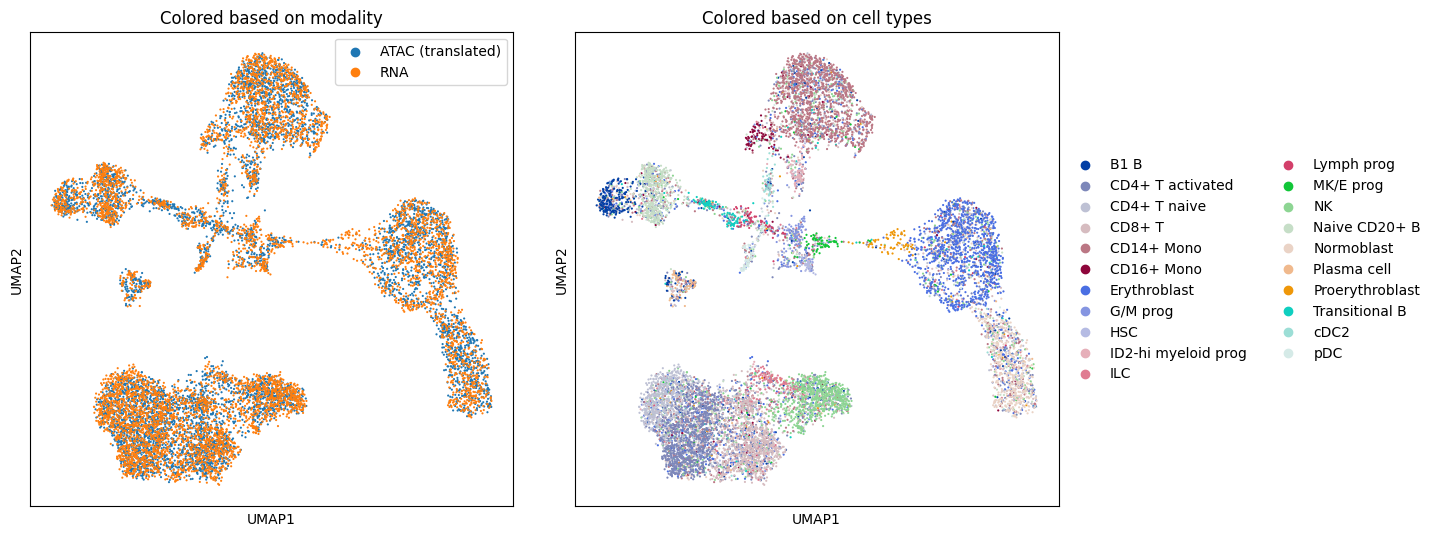

In [19]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (res[0], target), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
lm = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=source)
lms = np.zeros((len(adata),1))
lms[:] = None
lms[adata.obs["batch"] == "ATAC (translated)"] = lm
adata.obs["left_marginals"] = lms
rm = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=target)
rms = np.zeros((len(adata),1))
rms[:] = None
rms[adata.obs["batch"] == "RNA"] = rm
adata.obs["right_marginals"] = rms

In [ ]:
adata[adata.obs["batch"] == "ATAC (translated)"].obs[["cell_type", "left_marginals"]].groupby("cell_type").mean()

In [ ]:
adata[adata.obs["batch"] == "RNA"].obs[["cell_type", "right_marginals"]].groupby("cell_type").mean()

In [ ]:
foscttm(gex_predicted[..., 25:], target[..., 25:])

In [ ]:
foscttm(gex_predicted[..., :25], target[..., :25])

In [ ]:
foscttm(jnp.mean(gex_predicted, axis=0)[..., 10:], target[..., 10:])

In [ ]:
gex_predicted

In [ ]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_concat, seed=i)[0][0,...]

In [ ]:
gex_predicted = jnp.mean(jnp.asarray(res), axis=0)

In [ ]:
foscttm(gex_predicted, target_concat)

In [ ]:
foscttm(gex_predicted[..., 10:], target_concat[..., 10:])

In [ ]:
foscttm(gex_predicted[..., :10], target_concat[..., :10])

In [ ]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [ ]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

In [ ]:
sc.pl.umap(adata, color="var", vmax="p99")

In [ ]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.dendrogram(adata, groupby="cell_type")

In [ ]:
sc.pl.correlation_matrix(adata, groupby="cell_type")